in this notebook we implement excercise 3, including pytorch

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys, os
sys.path.append(os.getcwd())

In [6]:
import numpy as np, torch 
from torch import nn
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from helpers import *
import pdb

In [7]:
np.random.seed(42)
torch.manual_seed(42)


# ridge

In [8]:
class Ridge_Regression:

    def __init__(self, lambd):
        self.lambd = lambd

    def fit(self, X, Y):

        """
        Fit the ridge regression model to the provided data.
        :param X: The training features.
        :param Y: The training labels.
        """

        Y = 2 * (Y - 0.5) # transform the labels to -1 and 1, instead of 0 and 1.

        ########## YOUR CODE HERE ##########
        # add a feature of 1's for bias
        N = X.shape[1]
        X = np.vstack([X, np.ones((1, N))])
        # compute the ridge regression weights using the formula from class / exercise.
        # you may not use np.linalg.solve, but you may use np.linalg.inv
        feat_dim, N = X.shape # feat_dim is d+1 (includes bias)

        # Term 1: (XX^T / N + lambda * I)^-1
        XXT = X @ X.T
        I = np.eye(feat_dim)
        term1 = np.linalg.inv((XXT / N) + self.lambd * I)
        
        # Term 2: (XY^T / N)
        term2 = (X @ Y.T) / N
        self.W = term1 @ term2

        ####################################
        pass

    def predict(self, X):
        """
        Predict the output for the provided data.
        :param X: The data to predict. 
        :return: The predicted output. 
        we want to calculate W @ X, where X = [n_feats + 1, N]
        since W.shape = 3,1, 
        we can take its transpose and multiply by X to get ouput in [1,N]
        """
        N = X.shape[1]
        X =  np.vstack([X, np.ones((1, N))])
        preds = self.W.T @ X
        preds = np.where(preds < 0, 0,1)


        return preds

In [9]:
def get_accuracy(model,x,y):
    preds = model.predict(x)
    return (preds == y).mean()

In [10]:
def run_ridge_experiments(x_train, y_train, x_val, y_val, x_test, y_test, lambdas, plot = False):
    """
    Runs Ridge Regression for a list of lambdas, returns a DataFrame of results
    and the dictionary of trained models.
    """
    np.random.seed(42)
    torch.manual_seed(42)

    records = []
    trained_models = {}

    for l in lambdas:
        # Train
        model = Ridge_Regression(l)
        model.fit(x_train, y_train)
        
        # Evaluate
        t_acc = get_accuracy(model, x_train, y_train)
        v_acc = get_accuracy(model, x_val, y_val)
        test_acc = get_accuracy(model, x_test, y_test)
        
        records.append({
            'Lambda': l,
            'Train Accuracy': t_acc,
            'Validation Accuracy': v_acc,
            'Test Accuracy': test_acc
        })
        trained_models[l] = model

    # Create DataFrame
    df_results = pd.DataFrame(records)

    # Display Table
    print("Ridge Regression Results:")
    print(df_results)
    
    # Extract best model details
    best_row = df_results.loc[df_results['Validation Accuracy'].idxmax()]
    print(f"\nBest Lambda according to Validation: {best_row['Lambda']}")
    print(f"Test Accuracy of Best Model: {best_row['Test Accuracy']}")
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(df_results['Lambda'], df_results['Train Accuracy'], marker='o', label='Train')
        plt.plot(df_results['Lambda'], df_results['Validation Accuracy'], marker='o', label='Validation')
        plt.plot(df_results['Lambda'], df_results['Test Accuracy'], marker='o', label='Test')
        plt.xlabel('Lambda')
        plt.ylabel('Accuracy')
        plt.title('Ridge Regression Accuracy vs Lambda')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    
    
    return df_results, trained_models

In [11]:

class TransposeAdapter:
    """
    A simple wrapper to adapt the Ridge_Regression model (which expects 2xN)
    to the helper function (which sends Nx2).
    """
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        # X comes from the helper as (N_samples, 2)
        # We transpose it to (2, N_samples) for our model
        return self.model.predict(X.T)

def plot_best_and_worst_lambda(df_results, models_dict, x_test, y_test, save=False):
    """
    Identifies the best and worst lambdas based on validation accuracy
    and plots their decision boundaries using the test set.

    :param df_results: DataFrame containing 'Lambda' and 'Validation Accuracy'
    :param models_dict: Dictionary {lambda: model_object}
    :param x_test: Test features (Shape: 2 x N)
    :param y_test: Test labels
    """
    
    # 1. Identify Best and Worst Lambdas
    best_row = df_results.loc[df_results['Validation Accuracy'].idxmax()]
    worst_row = df_results.loc[df_results['Validation Accuracy'].idxmin()]
    
    best_lambda = best_row['Lambda']
    worst_lambda = worst_row['Lambda']
    
    print(f"Best Lambda: {best_lambda} (Val Acc: {best_row['Validation Accuracy']:.4f})")
    print(f"Worst Lambda: {worst_lambda} (Val Acc: {worst_row['Validation Accuracy']:.4f})")

    # 2. Prepare Data for Helper (Helper expects N x 2, our x_test is 2 x N)
    X_plot = x_test.T 
    
    # 3. Plot Worst Model
    print(f"\nPlotting Worst Model (Lambda={worst_lambda})...")
    worst_model = models_dict[worst_lambda]
    plot_decision_boundaries(
        TransposeAdapter(worst_model), 
        X_plot, 
        y_test, 
        title=f'Decision Boundary (Worst $\lambda={worst_lambda}$)',
         save=save
    )

    # 4. Plot Best Model
    print(f"Plotting Best Model (Lambda={best_lambda})...")
    best_model = models_dict[best_lambda]
    plot_decision_boundaries(
        TransposeAdapter(best_model), 
        X_plot, 
        y_test, 
        title=f'Decision Boundary (Best $\lambda={best_lambda}$)',
        save=save
    )

<>:45: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\l'
<>:45: SyntaxWarning: invalid escape sequence '\l'
<>:56: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1478/1678418400.py:45: SyntaxWarning: invalid escape sequence '\l'
  title=f'Decision Boundary (Worst $\lambda={worst_lambda}$)',
/tmp/ipykernel_1478/1678418400.py:56: SyntaxWarning: invalid escape sequence '\l'
  title=f'Decision Boundary (Best $\lambda={best_lambda}$)',


### helpers

# numpy SGD

In [12]:

def run_gradient_descent():
    np.random.seed(42)
    torch.manual_seed(42)
    # 1. Initialization
    x, y = 0.0, 0.0
    lr = 0.1
    iterations = 1000
    
    # Store history for plotting
    history_x = [x]
    history_y = [y]

    # 2. Optimization Loop
    for i in range(iterations):
        # Derivatives of f(x, y) = (x - 3)^2 + (y - 5)^2
        # df/dx = 2*(x - 3)
        # df/dy = 2*(y - 5)
        grad_x = 2 * (x - 3)
        grad_y = 2 * (y - 5)
        
        # Update step
        x = x - lr * grad_x
        y = y - lr * grad_y
        
        history_x.append(x)
        history_y.append(y)

    final_point = (x, y)
    print(f"Final point reached: ({x:.4f}, {y:.4f})")

    # 3. Plotting
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with color mapping to iterations
    sc = plt.scatter(history_x, history_y, c=range(len(history_x)), cmap='viridis', s=10)
    plt.colorbar(sc, label='Iteration')
    
    # Mark the start and end
    plt.scatter(history_x[0], history_y[0], color='red', label='Start (0,0)', marker='x', s=100)
    plt.scatter(history_x[-1], history_y[-1], color='red', label='End', marker='*', s=100)

    plt.title(r'Gradient Descent Optimization of $f(x, y) = (x - 3)^2 + (y - 5)^2$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()



# logistic pytorch

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import plot_decision_boundaries

In [14]:
class Logistic_Regression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim,output_dim)



    def forward(self, x):
        """
        Computes the output of the linear operator.
        :param x: The input to the linear operator.
        :return: The transformed input.
        """
        logits = self.linear(x)
        
        return logits

    def predict(self, x):
        """
        THIS FUNCTION IS NOT NEEDED FOR PYTORCH. JUST FOR OUR VISUALIZATION
        """
        with torch.no_grad():
            x = torch.from_numpy(x).float().to(self.linear.weight.data.device)
            x = self.forward(x)
            x = nn.functional.softmax(x, dim=1)
            x = x.detach().cpu().numpy()
            x = np.argmax(x, axis=1)
        return x

In [15]:
class Logistic_Multi_Class(Logistic_Regression):
    def __init__(self, input_dim, output_dim):
        super().__init__(input_dim, output_dim)

    def predict(self, x):
        with torch.no_grad():
            x = torch.from_numpy(x).float().to(self.linear.weight.device)
            logits = self.forward(x)
            probs = nn.functional.softmax(logits, dim=1)
            return torch.argmax(probs, dim=1).detach().cpu().numpy()

In [53]:
def get_loaders(train_df, val_df, test_df, batch_size=32):
    def df_to_tensor(df):
        # Assumes format: [long, lat, country_id]
        x = torch.tensor(df.iloc[:, :2].values, dtype=torch.float32)
        y = torch.tensor(df.iloc[:, 2].values, dtype=torch.long)
        return TensorDataset(x, y)
    eval_batch_size = 1024 
    train_loader = DataLoader(df_to_tensor(train_df), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(df_to_tensor(val_df), batch_size=eval_batch_size, shuffle=False)
    test_loader = DataLoader(df_to_tensor(test_df), batch_size=eval_batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [17]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

In [30]:
def train_experiment(train_df, val_df, test_df, 
                     param_values, param_name='lr', 
                     epochs=10, batch_size=32,
                     step_size=None, gamma=0.1, 
                     fixed_lr=0.01,verbose=False,binary=False):
    """
    Generic training loop. 
    - Can iterate over 'lr' (Section 6.3/6.4) or 'lambda' (Section 6.4 Bonus).
    - Handles Scheduler (Section 6.4) via step_size.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader, test_loader = get_loaders(train_df, val_df, test_df, batch_size)
    n_classes = len(train_df.iloc[:, 2].unique())
    
    results = {}
    if verbose: print(f"Starting Training: {len(param_values)} configs over {epochs} epochs...")

    for val in param_values:
        # Resolve hyperparameters
        lr = val if param_name == 'lr' else fixed_lr
        wd = val if param_name == 'lambda' else 0.0 # Weight Decay = Lambda

        # Init Model & Optimizer
        model_cls = Logistic_Regression if binary else Logistic_Multi_Class
        model = model_cls(input_dim=2, output_dim=n_classes).to(device)
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
        criterion = nn.CrossEntropyLoss()
        
        # Init Scheduler if step_size is provided (Section 6.4)
        scheduler = None
        if step_size:
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        
        # Stats Storage
        stats = {k: [] for k in ['train_loss', 'val_loss', 'test_loss', 
                                 'train_acc', 'val_acc', 'test_acc']}

        # Epoch Loop
        for epoch in range(epochs):
            model.train()
            ep_loss, ep_correct, ep_total = 0, 0, 0
            
            for X, y in train_loader:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                out = model(X)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()
                
                ep_loss += loss.item() * X.size(0)
                _, pred = torch.max(out, 1)
                ep_correct += (pred == y).sum().item()
                ep_total += X.size(0)
            
            if scheduler: scheduler.step()

            # Record Epoch Metrics
            stats['train_loss'].append(ep_loss / ep_total)
            stats['train_acc'].append(ep_correct / ep_total)
            
            v_loss, v_acc = evaluate(model, val_loader, criterion, device)
            t_loss, t_acc = evaluate(model, test_loader, criterion, device)
            
            stats['val_loss'].append(v_loss); stats['val_acc'].append(v_acc)
            stats['test_loss'].append(t_loss); stats['test_acc'].append(t_acc)

        results[val] = {'model': model, 'stats': stats}
        if verbose: print(f"Finished {param_name}={val} | Final Val Acc: {stats['val_acc'][-1]:.4f}")

    return results

In [35]:
def plot_training_results(entry, title, plot_acc=True):
    """
    Plots training history and optionally prints model parameters.
    
    Parameters:
    - entry: The dictionary containing {'model': ..., 'stats': ...}
    - title: String title for the plots
    - plot_acc: Boolean, if True plots (1x2) Loss & Accuracy, else just Loss.
    """
    stats = entry['stats']
    model = entry['model']
    epochs = range(1, len(stats['train_loss']) + 1)
    
    # Setup Figure: 1 or 2 subplots
    if plot_acc:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
        ax2 = None

    # --- Plot Loss (Always) ---
    ax1.plot(epochs, stats['train_loss'], 'o-', label='Train')
    ax1.plot(epochs, stats['val_loss'], 's-', label='Val')
    ax1.plot(epochs, stats['test_loss'], '^-', label='Test')
    ax1.set_title(f'{title} - Loss Curves')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- Plot Accuracy (Optional) ---
    if plot_acc and ax2 is not None:
        ax2.plot(epochs, stats['train_acc'], 'o-', label='Train')
        ax2.plot(epochs, stats['val_acc'], 's-', label='Val')
        ax2.plot(epochs, stats['test_acc'], '^-', label='Test')
        ax2.set_title(f'{title} - Accuracy Curves')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- Print Parameters ---
    print(f"\n[{title}] Best Model Parameters:")
    # Detach to numpy for clean printing
    print('Weight:', model.linear.weight.detach().cpu().numpy())
    print('Bias:', model.linear.bias.detach().cpu().numpy())

In [40]:
def run_section_6_3():
    np.random.seed(42)
    torch.manual_seed(42)
    print("\n=== Section 6.3: Binary Logistic Regression ===")
    
    # 1. Load Data
    train, val, test = load_data(binary=True)
    
    # 2. Train Grid
    lrs = [0.1, 0.01, 0.001]
    results = train_experiment(train, val, test, 
                               param_values=lrs, 
                               param_name='lr', 
                               epochs=10, 
                               step_size=None,
                              binary=True,
                              ) # No decay 

    # 3. Select Best Model (Q1)
    best_lr = max(results, key=lambda k: results[k]['stats']['val_acc'][-1])
    best_entry = results[best_lr]
    print(f"\nBest Binary Model LR: {best_lr} (Test Acc: {best_entry['stats']['test_acc'][-1]:.4f})")
    
    # Q1 Visualization
    X_test = test[['long', 'lat']].values
    y_test = test['country'].values
    plot_decision_boundaries(best_entry['model'], X_test, y_test, 
                             title=f'Binary LogReg (LR={best_lr})')

    # 4. Plot Loss Curves (Q2)
    plot_training_results(best_entry, 
                      title=f"Binary Case (LR={best_lr})", 
                      plot_acc=False)



In [46]:
def run_section_6_4():
    np.random.seed(42)
    torch.manual_seed(42)
    print("\n=== Section 6.4: Multi-Class Logistic Regression ===")
    
    # 1. Load Data
    train, val, test = load_data(binary=False)
    
    # 2. Train Grid
    lrs = [0.01, 0.001, 0.0003]
    results = train_experiment(train, val, test, 
                               param_values=lrs, 
                               param_name='lr', 
                               epochs=30, 
                               step_size=5,  # Decay every 5 epochs
                               gamma=0.3,
                              binary=False,
                              verbose=True)    # By factor of 0.3

    # 3. Select Best Model
    best_lr = max(results, key=lambda k: results[k]['stats']['val_acc'][-1])
    best_entry = results[best_lr]
    print(f"\nBest Multi Model LR: {best_lr} (Test Acc: {best_entry['stats']['test_acc'][-1]:.4f})")

    # Q1: Test & Val Acc vs LR
    plot_training_results(best_entry, 
                      title=f"Multi-Class Case (LR={best_lr})", 
                      plot_acc=True)
    
    # Visualization
    X_test = test[['long', 'lat']].values
    y_test = test['country'].values
    plot_decision_boundaries(best_entry['model'], X_test, y_test, 
                             title=f'Multi-Class LogReg (LR={best_lr})')

## trees

In [49]:
from sklearn.tree import DecisionTreeClassifier

def run_tree_experiments():
    print("\n=== Section 6.4 Q3 & Q4: Decision Trees ===")

    # 1. Load Data (Multi-class)
    # Reusing the load_data function from your previous code
    train_df, _, test_df = load_data(binary=False)

    # Convert to Numpy arrays for sklearn
    X_train = train_df[['long', 'lat']].values
    y_train = train_df['country'].values
    X_test = test_df[['long', 'lat']].values
    y_test = test_df['country'].values

    # 2. Run Experiments for Depth 2 and 10
    depths = [2, 10]

    for depth in depths:
        # Initialize and Train
        # random_state=42 ensures reproducibility as requested in Sec 2.1
        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)

        # Evaluate
        train_acc = clf.score(X_train, y_train)
        test_acc = clf.score(X_test, y_test)

        print(f"\nDecision Tree (max_depth={depth}):")
        print(f"  Train Accuracy: {train_acc:.4f}")
        print(f"  Test Accuracy:  {test_acc:.4f}")

        # Visualize
        plot_title = f'Decision Tree (max_depth={depth}) - Test Acc: {test_acc:.2f}'
        plot_decision_boundaries(clf, X_test, y_test, title=plot_title)

# data

In [23]:
# load all datasets
data_path = Path(os.getcwd())
list(data_path.glob('*.csv'))

[PosixPath('/home/jesse/repos/IML_2025/ex_3/train_multiclass.csv'),
 PosixPath('/home/jesse/repos/IML_2025/ex_3/train.csv'),
 PosixPath('/home/jesse/repos/IML_2025/ex_3/test_multiclass.csv'),
 PosixPath('/home/jesse/repos/IML_2025/ex_3/test.csv'),
 PosixPath('/home/jesse/repos/IML_2025/ex_3/validation_multiclass.csv'),
 PosixPath('/home/jesse/repos/IML_2025/ex_3/validation.csv')]

In [24]:
# Assuming data_path is a pathlib Path object, otherwise use os.path.join
# Binary classification data (Sections 2 & 3)
train = pd.read_csv(data_path / 'train.csv')
val = pd.read_csv(data_path / 'validation.csv')
test = pd.read_csv(data_path / 'test.csv')


# Multi-class data (Section 6.4)
train_multi = pd.read_csv(data_path / 'train_multiclass.csv')
val_multi = pd.read_csv(data_path / 'validation_multiclass.csv')
test_multi = pd.read_csv(data_path / 'test_multiclass.csv')

In [25]:
def load_data(binary:bool = True, to_dl = False):
    data_path = Path(os.getcwd())
    
    suffix = '' if binary else '_multiclass'
    train_df = pd.read_csv(data_path / f'train{suffix}.csv')
    val_df = pd.read_csv(data_path / f'validation{suffix}.csv')
    test_df = pd.read_csv(data_path / f'test{suffix}.csv')
    return train_df, val_df,test_df


    

# experiments

# pytorch :)

In [26]:
import torch.functional as F

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


=== Section 6.3: Binary Logistic Regression ===

Best Binary Model LR: 0.001 (Test Acc: 0.9705)
(57600,)


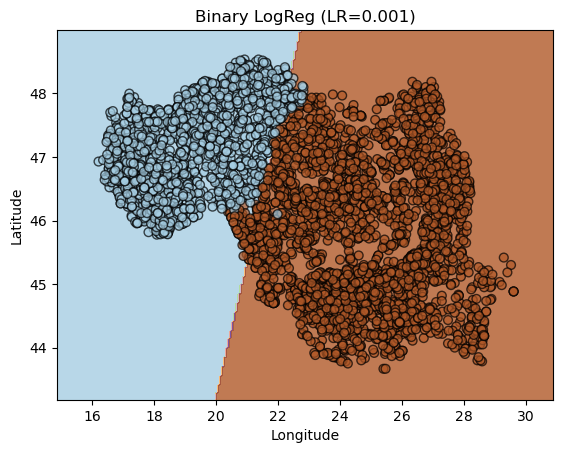

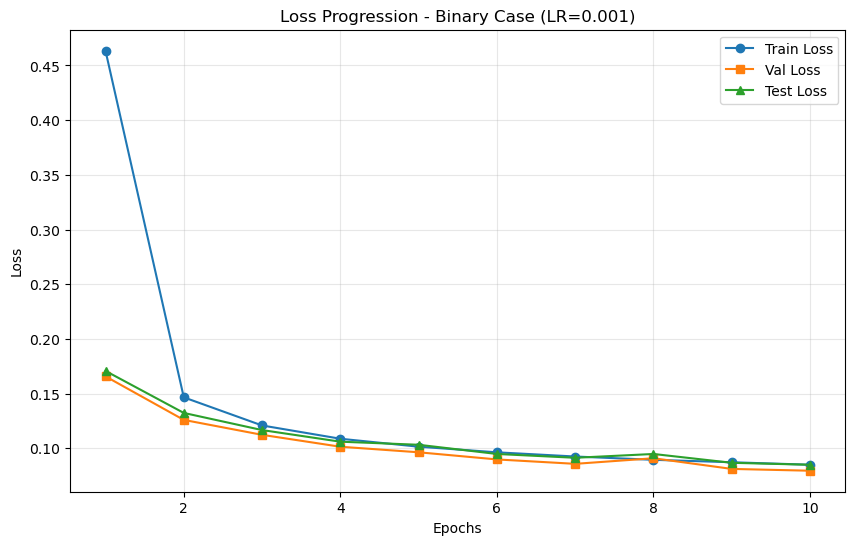

best model params:
weight [[-0.9230727   0.22282098]
 [ 0.9144364  -0.64565414]]
bias [-0.53698874  0.26090255]


In [33]:
run_section_6_3()

since the test and train loss follow the sametrajectory of the train loss, we conclude that the model generalised to the to test and val data

we note that the best logistic model trained with SGD performed on par with the analytically solved bess ridge regressor: val acc of `0.9756` vs `0.9745`. 
this stands to reason, since we on both cases we trained a linear regressor. and since the loss function is convex, sgd will necessarily arrive at a global minimum. 

## multi class


=== Section 6.4: Multi-Class Logistic Regression ===
Starting Training: 3 configs over 30 epochs...
Finished lr=0.01 | Final Val Acc: 0.8421
Finished lr=0.001 | Final Val Acc: 0.7985
Finished lr=0.0003 | Final Val Acc: 0.8065

Best Multi Model LR: 0.01 (Test Acc: 0.8424)


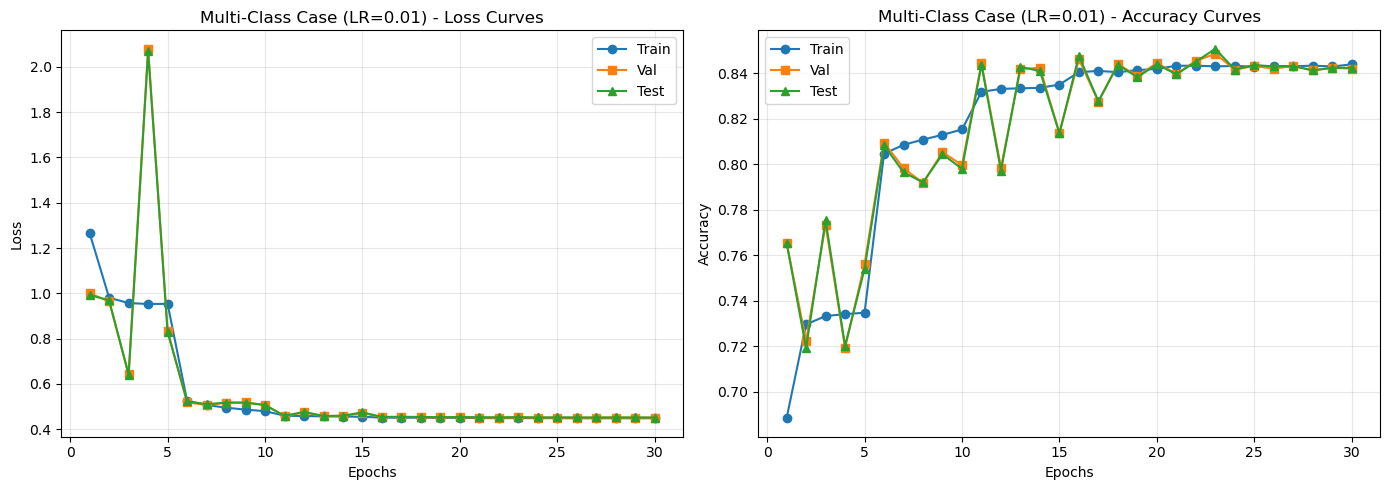


[Multi-Class Case (LR=0.01)] Best Model Parameters:
Weight: [[ 0.59820604  0.17227921]
 [-1.8288555   0.6182558 ]
 [-0.28890586  0.4935465 ]
 [ 1.6602091  -0.18555602]
 [ 0.35842735  0.17713459]]
Bias: [ 0.3223333   1.3878907  -2.8782086  -0.73256683  3.6065736 ]
(57840,)


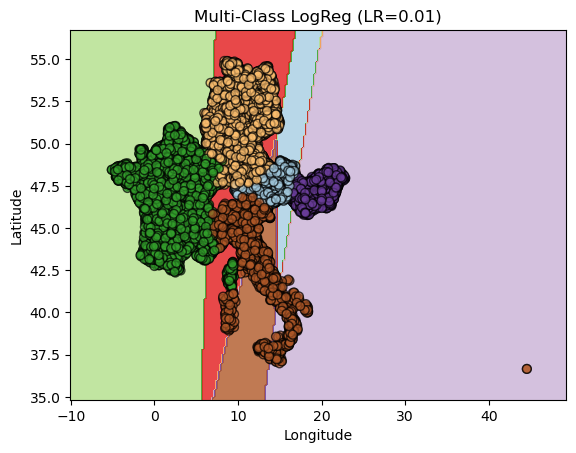

In [52]:
run_section_6_4()

we can say the model generalised, in the narrow sense that the generalisation gap is small, as can be seen from the overlap of the lines of train and test loss and acc respectively. although we see that it was only near the end that the model converged properly, showing the importance of the decaying the larning rate. 

### tree results


=== Section 6.4 Q3 & Q4: Decision Trees ===

Decision Tree (max_depth=2):
  Train Accuracy: 0.7511
  Test Accuracy:  0.7502
(57840,)


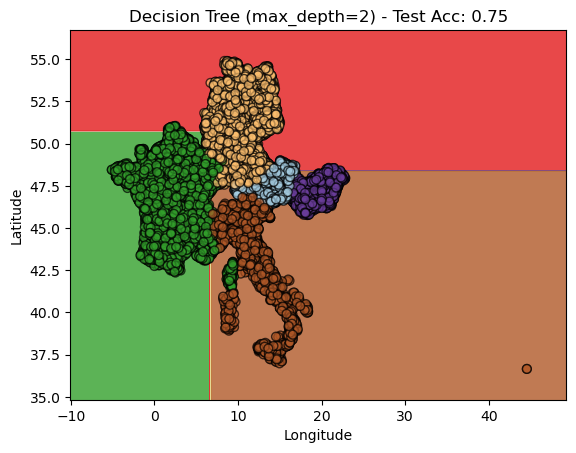


Decision Tree (max_depth=10):
  Train Accuracy: 0.9974
  Test Accuracy:  0.9969
(57840,)


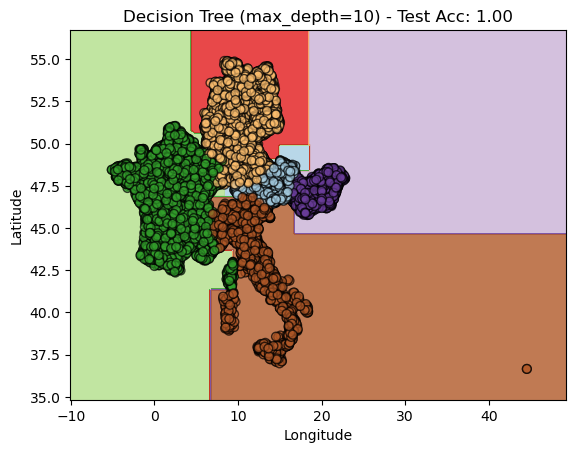

In [51]:
run_tree_experiments()

while the data is unsuitable for simple linear regression, meaning it isn' cleanly linearly seperable, the regressor slightly outperformed the tree. the main reason for this is the shallowness of the tree - a depth of two, menaing a maximum of 4 leafs. since the data can't be fitted to 4 rectangles, the tree is less suitbale.

on the other hand, when we increase the depth (and thus leaves) the model can perform perfectly. since there are 5 classes with on the whole clear boundaries, the model can easily find a set of leaves (rectangles) that match them

# numpy sgd output


### Explanation of the Math:
The function is $f(x, y) = (x - 3)^2 + (y - 5)^2$.
To minimize it, we compute the partial derivatives:
*   $\frac{\partial f}{\partial x} = 2(x - 3)$
*   $\frac{\partial f}{\partial y} = 2(y - 5)$

In every step, we subtract the gradient scaled by the learning rate from the current position. 

Final point reached: (3.0000, 5.0000)


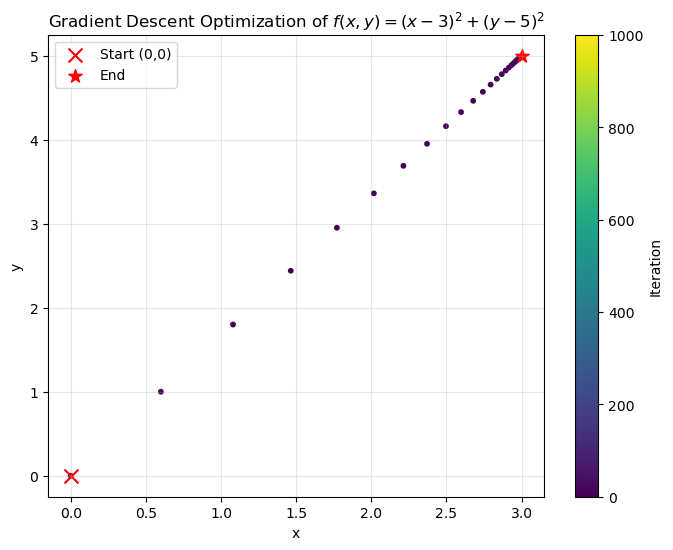

In [45]:
run_gradient_descent()

## loop ridge

create a table:
model, train, val, test acc

In [50]:
x_train, y_train, x_val, y_val, x_test, y_test = load_binary_data()


Ridge Regression Results:
   Lambda  Train Accuracy  Validation Accuracy  Test Accuracy
0     0.0        0.970185             0.971134       0.966295
1     2.0        0.972925             0.974505       0.969665
2     4.0        0.973609             0.974505       0.970718
3     6.0        0.966709             0.967341       0.967348
4     8.0        0.955041             0.958281       0.955551
5    10.0        0.941056             0.943321       0.943965

Best Lambda according to Validation: 2.0
Test Accuracy of Best Model: 0.9696650516115441


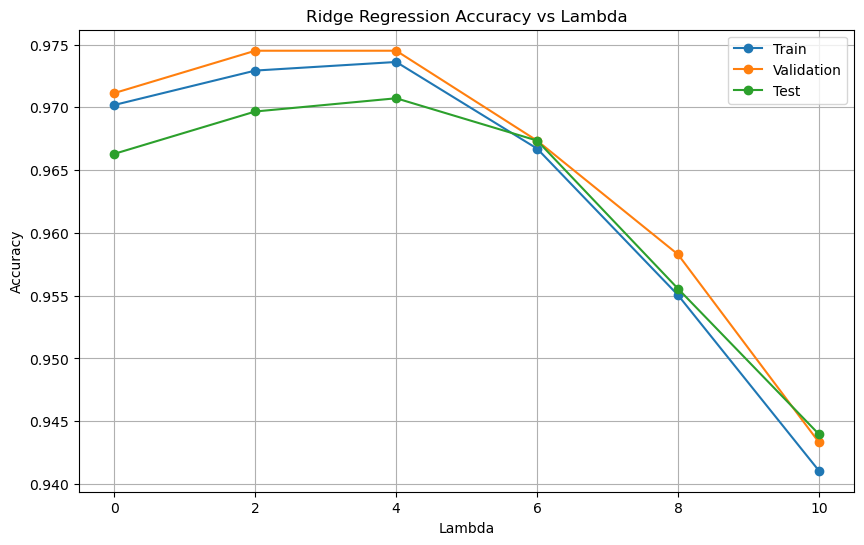

In [16]:
# --- Usage Example ---
lambdas = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0]
df_res, model_dict = run_ridge_experiments(x_train, y_train, x_val, y_val, x_test, y_test, lambdas, plot=True)

Best Lambda: 2.0 (Val Acc: 0.9745)
Worst Lambda: 10.0 (Val Acc: 0.9433)

Plotting Worst Model (Lambda=10.0)...
(57600,)


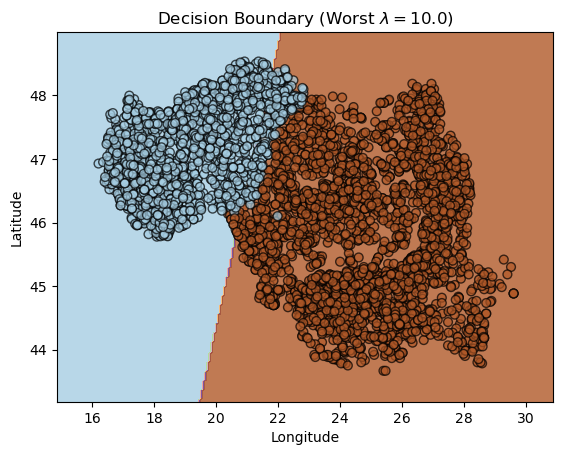

Plotting Best Model (Lambda=2.0)...
(57600,)


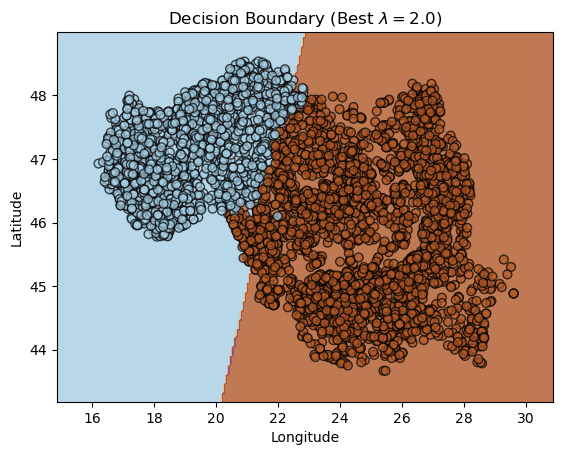

In [21]:
# --- Usage ---
# Assuming x_test is currently (2, N) from the previous step
plot_best_and_worst_lambda(df_res, model_dict, x_test, y_test,save=False)

the diffenret lambdas shift the boundary. we see that in the best model the boundary intersects the Longitude at `02`, while in the worst model it does so at 19.
we can examine the model params:


In [34]:
best,worst = model_dict[2.0],model_dict[10.0]
best.W, worst.W

(array([ 0.19782051, -0.0923567 ,  0.00035015]),
 array([ 0.11980601, -0.05401592, -0.00030748]))

In [35]:
np.linalg.norm(best.W), np.linalg.norm(worst.W)

(np.float64(0.21831819714950573), np.float64(0.13142029697964172))

and see that as epected, the weigths in the worst model are smaller, due to the larger lambda. 

## analytical ridge

In [37]:
train = pd.read_csv(data_path / 'train.csv')
val = pd.read_csv(data_path / 'validation.csv')
test = pd.read_csv(data_path / 'test.csv')

In [38]:
y_train_orig = train.iloc[:,2]
X_train_orig = train.iloc[:,:2].T
N = y_train_orig.shape[0]

# Extend X with a row of 1s
X_train = np.vstack([X_train_orig, np.ones((1, N))])
# Transform labels: 0 -> -1, 1 -> 1
# Also reshape to (1, N) for requirements
Y_train = np.where(y_train_orig == 0, -1, 1).reshape(-1,N)

print(f"X_train shape: {X_train.shape} (should be 3 x {N})")
print(f"Y_train shape: {Y_train.shape} (should be 1 x {N})")

X_train shape: (3, 37968) (should be 3 x 37968)
Y_train shape: (1, 37968) (should be 1 x 37968)


we calculate the precise expression:

In [39]:
X = X_train
Y = Y_train
lambda_val = 0.0
feat_dim, N = X.shape # feat_dim is d+1 (includes bias)

# Term 1: (XX^T / N + lambda * I)^-1
XXT = X @ X.T
I = np.eye(feat_dim)
term1 = np.linalg.inv((XXT / N) + lambda_val * I)

# Term 2: (XY^T / N)
XYT = X @ Y.T
term2 = XYT / N

# W* = term1 * term2
# Result is shape (d+1, 1), representing [w1, w2, b]^T
W_opt = term1 @ term2

W_opt

array([[ 0.2103381 ],
       [-0.24103747],
       [ 6.60787159]])

In [40]:
W_opt.shape

(3, 1)

In [41]:
#predict:

X = test[['long', 'lat']].values.T  # Shape: (2, N)
N = X.shape[1]
X =  np.vstack([X, np.ones((1, N))])
X.shape

(3, 4747)

we want to calculate W @ X, where X = [n_feats + 1, N]
since W.shape = 3,1, 
we can take its transpose and multiply by X to get ouput in [1,N]

In [42]:
pred = W_opt.T @ X
pred.shape

(1, 4747)

In [43]:
pred = np.where(pred < 0, -1,1)
pred

array([[ 1,  1, -1, ..., -1,  1,  1]], shape=(1, 4747))